In [9]:
%matplotlib inline

# Filter warnings
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

from sklearn.decomposition import PCA

from deepod.models.tabular import DeepSVDD, DeepIsolationForest, ICL, GOAD
from deepod.models.time_series import AnomalyTransformer, TimesNet, DeepIsolationForestTS, DCdetector
import torch

plt.rcParams.update({'font.size': 15})

# Import us custom classes
%run -i '../src/transfxns.py'
%run -i '../src/unsup_ml.py'
# Import ss custom class
%run -i '../src/ss_transfxns.py'
%run -i '../src/ss_ml.py'
%run -i '../src/sup_ml.py'

%matplotlib inline

%reload_ext autoreload
%autoreload 2

# Instantiate the classes of unspervised learning
transfxn = TransformationPipeline()
model = UnsupervisedModels()
scaler = StandardScaler()

# Instantiate the class of semi-supervised learning
# transfxn_ss = TransformationPipelineSS()
# model_ss = SemiSupervised()

In [3]:
csv_file_path = 'eps_hour.csv'

df_total = pd.read_csv(csv_file_path)
df_total.columns = ['create_time','count']
min_value = 0.2
max_value = 0.8
max_count = df_total['count'].max()
min_count = df_total['count'].min()

print(max_count)
print(min_count)

7680227
1


In [6]:
def preprocessing(df):
    df['create_time'] = pd.to_datetime(df['create_time'])
    df['hour'] = df['create_time'].dt.hour
    # Extract the minute part of the 'create_time' column
    df['minute'] = df['create_time'].dt.minute

    df['day'] = df['create_time'].dt.dayofweek

    # Assuming df is your DataFrame with a 'minute' column
    # Convert the 'minute' column to numeric (to handle any non-numeric entries)
    # df['minute'] = pd.to_numeric(df['minute'], errors='coerce')

    # # Generate a DataFrame with all minutes from 0 to 59
    # all_minutes = pd.DataFrame({'minute': range(60)})

    # # Merge the existing DataFrame with the generated DataFrame to fill missing minutes
    # df = pd.merge(all_minutes, df, on='minute', how='left')

    # Fill missing values with 0 for the 'count' column
    #df['count'].fillna(0, inplace=True)

    #df['count'] = min_value+(max_value-min_value)*(df['count']-min_count)/(max_count-min_count)
    first_index = df.index[df['minute'] == 0].min()

    data = []
    for i in range(int(len(df[first_index:])/60)):
        temp = df[60*i:(i+1)*60]['count'].values.tolist()
        temp = min_value+(max_value-min_value)*(temp-min_count)/(max_count-min_count)

        week = [0]*7
        week[df.iloc[24*i]['day']] = 1
        temp = np.concatenate((temp, week))

        hour = [0]*24
        hour[df.iloc[24*i]['hour']] = 1
        temp = np.concatenate((temp, hour))
        data.append(temp)

    return pd.DataFrame(data)

In [7]:
df = preprocessing(df_total)
#pca = PCA(n_components=10)
#df_pca = pca.fit_transform(df)
X_scaled = df
device = torch.device("cpu")
#X_train = torch.tensor(df.values, dtype=torch.float32)
#print(X_scaled.shape)

clf = DCdetector(device = device)
clf.fit(X_scaled)
scores = clf.decision_function(X_scaled)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


In [16]:
# Calculate the threshold based on the 90th percentile
threshold = pd.Series(scores).quantile(0.9)
#threshold = 1

# Create a list to store the labels ('attack' or 'normal')
labels = ['attack' if score >= threshold else 'normal' for score in scores]
# for i in range(len(labels)):
#     if labels[i]=='attack':
#         #print(X_scaled[i])
#         print(i)

# Create a DataFrame for visualization or further analysis
result_df = pd.DataFrame({'Anomaly Score': scores, 'Label': labels})

print(labels)

# PCA plot with raw predicted labels
#transfxn.pca_plot(scaler.fit_transform(X_scaled), labels, palette = ['r', 'lime'])

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'attack',

[[-0.12971152 -0.1386432  -0.13743028 ... -0.21048292 -0.20786293
  -0.21019315]
 [-0.1508337  -0.14290566 -0.16068465 ... -0.21048292 -0.20786293
  -0.21019315]
 [-0.15869835 -0.15860948 -0.16178155 ... -0.21048292 -0.20786293
  -0.21019315]
 ...
 [ 0.07948797  0.03701521  0.04224259 ... -0.21048292 -0.20786293
  -0.21019315]
 [-0.05039098 -0.03432499 -0.01084756 ... -0.21048292 -0.20786293
  -0.21019315]
 [-0.01556185 -0.02445401 -0.00931189 ... -0.21048292 -0.20786293
  -0.21019315]]
[[-1.08471613  0.02369353]
 [-1.10918668  0.02447071]
 [-1.12419708 -0.05254972]
 ...
 [-0.09086185  0.03606367]
 [-0.18050469 -0.07825277]
 [-0.07587312 -0.003336  ]]


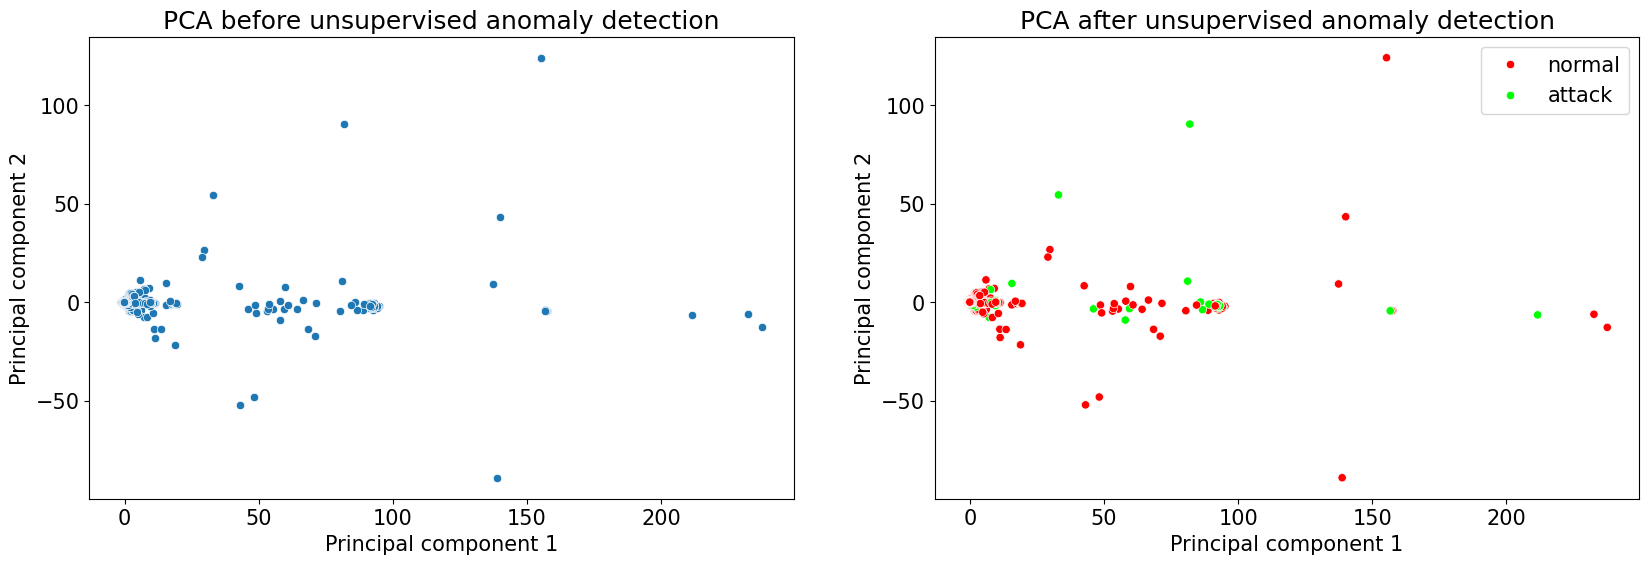

In [21]:
label = labels
X = StandardScaler().fit_transform(X_scaled)
print(X)
palette= ['r', 'lime']

pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)

print(X_reduced_pca)

# put in dataframe
X_reduced_pca = pd.DataFrame(data=X_reduced_pca)
X_reduced_pca.columns = ['PC1', 'PC2']
X_reduced_pca['class'] = label

# plot figure
plt.rcParams.update({'font.size': 15})
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(
            x='PC1', y='PC2', data=X_reduced_pca, palette=palette, ax=ax1
        )
sns.scatterplot(
            x='PC1',
            y='PC2',
            data=X_reduced_pca,
            hue='class',
            palette=palette,
            ax=ax2,
        )

# axes labels
ax1.set_xlabel('Principal component 1')
ax1.set_ylabel('Principal component 2')
ax2.set_xlabel('Principal component 1')
ax2.set_ylabel('Principal component 2')
ax1.set_title('PCA before unsupervised anomaly detection')
ax2.set_title('PCA after unsupervised anomaly detection')
ax2.legend(loc='best')

In [22]:
clf.save_model('/home/williamyeh/Documents/attack/network-intrusion/model/DCdetector_all.txt')